# <center>Recurrent Neural Networks</center>
## <center>Inclass Project 3 - MA4144</center>

This project contains 10 tasks/questions to be completed, some require written answers. Open a markdown cell below the respective question that require written answers and provide (type) your answers. Questions that required written answers are given in blue fonts. Almost all written questions are open ended, they do not have a correct or wrong answer. You are free to give your opinions, but please provide related answers within the context.

After finishing project run the entire notebook once and **save the notebook as a pdf** (File menu -> Save and Export Notebook As -> PDF). You are **required to upload this PDF on moodle**.

***

## Outline of the project

The aim of the project is to build a RNN model to suggest autocompletion of half typed words. You may have seen this in many day today applications; typing an email, a text message etc. For example, suppose you type in the four letter "univ", the application may suggest you to autocomplete it by "university".

![Autocomplete](https://d33v4339jhl8k0.cloudfront.net/docs/assets/5c12e83004286304a71d5b72/images/66d0cb106eb51e63b8f9fbc6/file-gBQe016VYt.gif)

We will train a RNN to suggest possible autocompletes given $3$ - $4$ starting letters. That is if we input a string "univ" hopefully we expect to see an output like "university", "universal" etc.

For this we will use a text file (wordlist.txt) containing 10,000 common English words (you'll find the file on the moodle link). The list of words will be the "**vocabulary**" for our model.

We will use the Python **torch library** to implement our autocomplete model. 

***


Use the below cell to use any include any imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random

## Section 1: Preparing the vocabulary

In [2]:
WORD_SIZE = 13

**Q1.** In the following cell provide code to load the text file (each word is in a newline), then extract the words (in lowercase) into a list.

For practical reasons of training the model we will only use words that are longer that $3$ letters and that have a maximum length of WORD_SIZE (this will be a constant we set at the beginning - you can change this and experiment with different WORD_SIZEs). As seen above it is set to $13$.

So out of the extracted list of words filter out those words that match our criteria on word length.

To train our model it is convenient to have words/strings of equal length. We will choose to convert every word to length of WORD_SIZE, by adding underscores to the end of the word if it is initially shorter than WORD_SIZE. For example, we will convert the word "university" (word length 10) into "university___" (wordlength 13). In your code include this conversion as well.

Store the processed WORD_SIZE lengthed strings in a list called vocab.

In [3]:
vocab=[]
with open('wordlist.txt', 'r') as file:
    for line in file:
        line=line[:-1]
        if len(line)>3 :
            if len(line)< WORD_SIZE:
                padding_length= WORD_SIZE-len(line)
                padding=""
                for i in range(padding_length):
                    padding+="_"
                vocab.append(line+padding)
            elif len(line) == WORD_SIZE:
                vocab.append(line)
print(vocab[0], vocab[1], vocab[2])            


aaron________ abandoned____ aberdeen_____


<font color='blue'>In the above explanation it was mentioned "for practical reasons of training the model we will only use words that are longer that $3$ letters and that have a certain maximum length". In your opinion what could be those practical? Will hit help to build a better model?</font>

**Answer** 
<span style="color:green">
Because when the word becomes very lengthy, we have to maintain a long context(i.e. need to unroll the RNN as the length that causes in-efficient weight matrix calculations)
</span>.

**Q2** To input words into the model, we will need to convert each letter/character into a number. as we have seen above, the only characters in our list vocab will be the underscore and lowercase english letters. so we will convert these $27$ characters into numbers as follows: underscore -> $0$, 'a' -> $1$, 'b' -> $2$, $\cdots$, 'z' -> $26$. In the following cell,

(i) Implement a method called char_to_num, that takes in a valid character and outputs its numerical assignment.

(ii) Implement a method called num_to_char, that takes in a valid number from $0$ to $26$ and outputs the corresponding character.

(iii) Implement a method called word_to_numlist, that takes in a word from our vocabulary and outputs a (torch) tensor of numbers that corresponds to each character in the word in that order. For example: the word "united_______" will be converted to tensor([21, 14,  9, 20,  5,  4,  0,  0,  0,  0,  0,  0,  0]). You are encouraged to use your char_to_num method for this.

(iv) Implement a method called numlist_to_word, that does the opposite of the above described word_to_numlist, given a tensor of numbers from $0$ to $26$, outputs the corresponding word. You are encouraged to use your  num_to_char method for this.

Note: As mentioned since we are using the torch library we will be using tensors instead of the usual python lists or numpy arrays. Tensors are the list equivalent in torch. Torch models only accept tensors as input and they output tensors.

In [4]:
def char_to_num(char):

    char_dict={'_':0,'a':1,'b':2,'c':3,'d':4,'e':5,'f':6,'g':7,'h':8,'i':9,'j':10,'k':11,'l':12,'m':13,'n':14,'o':15,'p':16,'q':17,'r':18,'s':19,'t':20,'u':21,'v':22,'w':23,'x':24,'y':25,'z':26}
    
    return(char_dict[char])

def num_to_char(num):

    num_dict={0:'_',1:'a',2:'b',3:'c',4:'d',5:'e',6:'f',7:'g',8:'h',9:'i',10:'j',11:'k',12:'l',13:'m',14:'n',15:'o',16:'p',17:'q',18:'r',19:'s',20:'t',21:'u',22:'v',23:'w',24:'x',25:'y',26:'z'}
    
    return(num_dict[num])

def word_to_numlist(word):
    temp_list=[]
    for c in word:
        temp_list.append(char_to_num(c))
    return(torch.tensor(temp_list))

def numlist_to_word(numlist):
    word=''
    for element in numlist:
        word+=num_to_char(int(element))
    
    return(word)
print(numlist_to_word(torch.tensor([21, 14, 9, 20, 5, 4, 0, 0, 0, 0, 0, 0, 0])))

united_______


<font color='blue'>We convert letter into just numbers based on their aphabetical order, I claim that it is a very bad way to encode data such as letters to be fed into learning models, please write your explanation to or against my claim. If you are searching for reasons, the keyword 'categorical data' may be useful. Although the letters in our case are not treated as categorical data, the same reasons as for categorical data is applicable. Even if my claim is valid, at the end it won't matter due to something called "embedding layers" that we will use in our model. What is an embedding layer? What is it's purpose? Explain.</font>

**Answer** 
<span style="color:green">
By assigning numerical values based on alphabetical order can mislead the model into thiking the letters have any intrinsic relationship based on numerical proximity. So your claim is right.
A trainable layer called an embedding layer converts input data—such discrete or category values like letters—into dense vectors of real numbers. Therefore an embedding layer can be used to mitigate the impact of poor encoding.
</span>.

## Section 2: Implementing the Autocomplete model

We will implement a RNN model based on LSTM. The [video tutorial](https://www.youtube.com/watch?v=tL5puCeDr-o) will be useful. Our model will be only one hidden layer, but feel free to sophisticate with more layers after the project for your own experiments.

Our model will contain all the training and prediction methods as single package in a class (autocompleteModel) we will define and implement below.

In [5]:
LEARNING_RATE = 0.005

In [6]:
class autocompleteModel(nn.Module):

    #Constructor
    def __init__(self, alphabet_size, embed_dim, hidden_size, num_layers):
        super().__init__()

        #Set the input parameters to self parameters
        self.alphabet_size = alphabet_size
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        #Initialize the layers in the model:
        #1 embedding layer, 1 - LSTM cell (hidden layer), 1 fully connected layer with linear activation

        self.embed = torch.nn.Embedding(num_embeddings=alphabet_size,
                                        embedding_dim=embed_dim)
        self.rnn = torch.nn.LSTMCell(input_size=embed_dim,
                                     hidden_size=hidden_size)
        self.fc = torch.nn.Linear(hidden_size, alphabet_size)

    #Feedforward
    def forward(self, character, hidden_state, cell_state):

        #Perform feedforward in order
        #1. Embed the input (one charcter represented by a number)
        #2. Feed the embedded output to the LSTM cell
        #3. Feed the LSTM output to the fully connected layer to obtain the output
        #4. return the output, and both the hidden state and cell state from the LSTM cell output

        embedded = self.embed(character)

        (hidden_state, cell_state) = self.rnn(embedded, (hidden_state, cell_state))
        output = self.fc(hidden_state)
        return output, hidden_state, cell_state

    #Intialize the first hidden state and cell state (for the start of a word) as zero tensors of required length.
    def initial_state(self):

        h0 = torch.zeros(1, self.hidden_size)
        c0 = torch.zeros(1, self.hidden_size)
        
        return (h0, c0)

    #Train the model in epochs given the vocab, the training will be fed in batches of batch_size
    def trainModel(self, vocab, epochs = 5, batch_size = 100):

        #Convert the model into train mode
        self.train()

        #Set the optimizer (ADAM), you may need to provide the model parameters  and learning rate
        #optimizer = 
        optimizer = torch.optim.Adam(self.parameters(), LEARNING_RATE)

        #Keep a log of the loss at the end of each training cycle.
        loss_log = []

        # Loss function
        criterion = torch.nn.CrossEntropyLoss()

        for e in range(epochs):
                #Shuffle the vocab list the start of each epoch
                random.shuffle(vocab)
                num_iter = len(vocab) // batch_size

                for i in range(num_iter):
                    vocab_batch = vocab[i * batch_size:(i + 1) * batch_size]
                    
    
                    #Set the loss to zero, initialize the optimizer with zero_grad at the beginning of each training cycle.
                    optimizer.zero_grad()
                    total_loss = 0
                    for word in vocab_batch:
    
                        #Initialize the hidden state and cell state at the start of each word.
                        hidden_state, cell_state = self.initial_state()
    
                        #Convert the word into a tensor of number and create input and target from the word
                        word_tensor=word_to_numlist(word)
                                            
                        #Input will be the first WORD_SIZE - 1 charcters and target is the last WORD_SIZE - 1 charcters
                        Input=word_tensor[:-1]
                        target=word_tensor[1:]
    
                        #Loop through each character (as a number) in the word
                        for c in range(WORD_SIZE - 1):
                            #Feed the cth character to the model (feedforward) and comput the loss (use cross entropy in torch)
                            output, hidden_state, cell_state = self.forward(Input[c].view(1), hidden_state, cell_state)
                            loss = criterion(output, target[c].view(1))
                            total_loss += loss
                    

                    #Compute the average loss per word in the batch and perform backpropagation (.backward())
                    avg_loss = total_loss / batch_size
                    avg_loss.backward()
                        
                    #Update model parameters using the optimizer
                    optimizer.step()
    
                    #Update the loss_log 
                    loss_log.append(avg_loss.item())

                print(f"Epoch {e+1}, Loss: {avg_loss.item()}")

        # Plot a graph of the variation of the loss.
        plt.plot(loss_log)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

    #Perform autocmplete given a sample of strings (typically 3-5 starting letters)
    def autocomplete(self, sample):

        #Convert the model into evaluation mode
        self.eval()

        completed_list = []

        #TODO: In the following loop for each sample item initialize hidden and cell states, then predict the remaining characters
        #You will have to convert the output into a softmax (you may use your softmax method from the last project) probability distribution, then use torch.multinomial 
        for literal in sample:
            hidden_state, cell_state = self.initial_state()
            literal_tensor = word_to_numlist(literal)
            for i in range(len(literal), WORD_SIZE):
                output, hidden_state, cell_state = self.forward(literal_tensor[-1].view(1), hidden_state, cell_state)

                probabilities = torch.nn.functional.softmax(output, dim=1)
                predicted_char = torch.multinomial(probabilities, 1).item()
                literal_tensor = torch.cat([literal_tensor, torch.tensor([predicted_char])])
                
            # Convert the tensor back to characters
            completed_word = numlist_to_word(literal_tensor)
            completed_list.append(completed_word)
                

        return(completed_list)

Epoch 1, Loss: 14.839669227600098
Epoch 2, Loss: 13.747432708740234
Epoch 3, Loss: 13.129802703857422
Epoch 4, Loss: 13.157696723937988
Epoch 5, Loss: 11.888566017150879


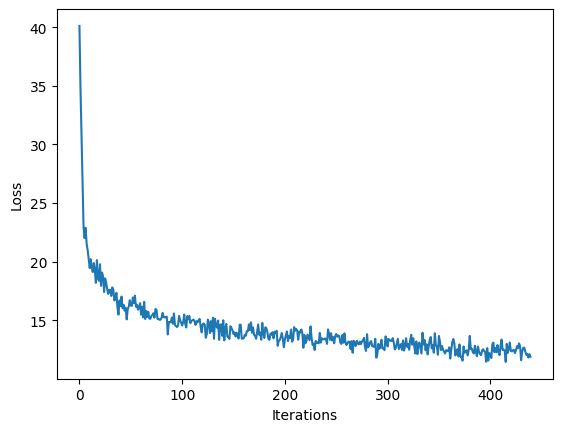

In [7]:
alphabet_size = 27  # _, a to z
embed_dim = 64  # Dimension of the embedding vector
hidden_size = 128  # Hidden state size in LSTM
num_layers = 2  

# Initialize the model
model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)

# Train the model
model.trainModel(vocab,epochs=5,batch_size=100)

In [8]:
# Sample input for autocomplete (starting letters of words)
sample = ['app', 'cak', 'butterf', 'icecrea']

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: app, Completed: apports______
Original: cak, Completed: caknowdung___
Original: butterf, Completed: butterfriptio
Original: icecrea, Completed: icecreaccerre


In [9]:
# Sample input for autocomplete (starting letters of words)
sample = ['univ', 'math', 'neur', 'engin','run','acquir','accen']

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: univ, Completed: univicialifia
Original: math, Completed: mathielder___
Original: neur, Completed: neurevy______
Original: engin, Completed: enginote_____
Original: run, Completed: runessions___
Original: acquir, Completed: acquirealty__
Original: accen, Completed: accenets_____


Epoch 1, Loss: 18.690725326538086
Epoch 2, Loss: 15.934913635253906
Epoch 3, Loss: 15.453068733215332
Epoch 4, Loss: 14.695504188537598
Epoch 5, Loss: 15.801111221313477


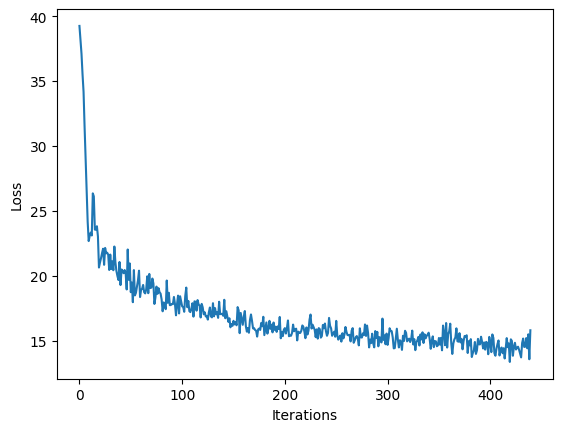

In [10]:
alphabet_size = 27  # _, a to z
embed_dim = 10  # Dimension of the embedding vector
hidden_size = 50  # Hidden state size in LSTM
num_layers = 2  

# Initialize the model
model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)

# Train the model
model.trainModel(vocab,epochs=5,batch_size=100)

In [11]:
# Sample input for autocomplete (starting letters of words)
sample = ['app', 'cak', 'butterf', 'icecrea']

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: app, Completed: appemsuens___
Original: cak, Completed: cakarcs______
Original: butterf, Completed: butterfassage
Original: icecrea, Completed: icecreactrog_


In [12]:
# Sample input for autocomplete (starting letters of words)
sample = ['univ', 'math', 'neur', 'engin','run','acquir','accen']

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: univ, Completed: univopkevus__
Original: math, Completed: mathxenet____
Original: neur, Completed: neurellates__
Original: engin, Completed: enginextel___
Original: run, Completed: runexgls_____
Original: acquir, Completed: acquirarmes__
Original: accen, Completed: accenitrertan


In [14]:
# Sample input for autocomplete (starting letters of words)
sample = ['aerop', 'comp', 'eleph', 'jupyt','eati','durab','follow','accord','success']

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: aerop, Completed: aeropraolled_
Original: comp, Completed: compinding___
Original: eleph, Completed: elephaprers__
Original: jupyt, Completed: jupytels_____
Original: eati, Completed: eating_______
Original: durab, Completed: durabimphestr
Original: follow, Completed: followars____
Original: accord, Completed: accordicters_
Original: success, Completed: successechige


Epoch 1, Loss: 14.033120155334473
Epoch 2, Loss: 13.10969352722168
Epoch 3, Loss: 12.90556812286377
Epoch 4, Loss: 11.30656909942627
Epoch 5, Loss: 10.280080795288086
Epoch 6, Loss: 11.016744613647461
Epoch 7, Loss: 9.79576587677002
Epoch 8, Loss: 9.96634578704834
Epoch 9, Loss: 9.60190486907959
Epoch 10, Loss: 9.0693998336792
Epoch 11, Loss: 8.827824592590332
Epoch 12, Loss: 8.292430877685547


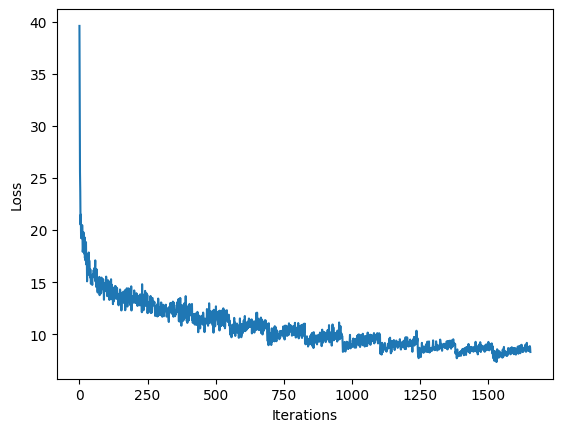

In [8]:
alphabet_size = 27  # _, a to z
embed_dim = 64  # Dimension of the embedding vector
hidden_size = 256  # Hidden state size in LSTM
num_layers = 2  

# Initialize the model
model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)

# Train the model
model.trainModel(vocab,epochs=12,batch_size=64)

In [9]:
# Sample input for autocomplete (starting letters of words)
sample = ['app', 'cak', 'butterf', 'icecrea','eat','univ', 'math', 'neur', 'engin','run','acquir','accen','aerop', 'comp', 'eleph', 'jupyt','eati','durab','follow','accord','success']

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: app, Completed: appatent_____
Original: cak, Completed: cakiraki_____
Original: butterf, Completed: butterfist___
Original: icecrea, Completed: icecreassembl
Original: eat, Completed: eatalent_____
Original: univ, Completed: univisiting__
Original: math, Completed: mathose______
Original: neur, Completed: neuresults___
Original: engin, Completed: enginull_____
Original: run, Completed: runulle______
Original: acquir, Completed: acquirecipes_
Original: accen, Completed: accenoited___
Original: aerop, Completed: aeropaste____
Original: comp, Completed: compatis_____
Original: eleph, Completed: elephandhead_
Original: jupyt, Completed: jupytooths___
Original: eati, Completed: eatinflument_
Original: durab, Completed: durabusiness_
Original: follow, Completed: followroop___
Original: accord, Completed: accordefined_
Original: success, Completed: successugmess


Epoch 1, Loss: 14.274423599243164
Epoch 2, Loss: 14.424825668334961
Epoch 3, Loss: 14.146395683288574
Epoch 4, Loss: 12.500521659851074
Epoch 5, Loss: 12.30088996887207
Epoch 6, Loss: 13.863349914550781
Epoch 7, Loss: 10.913926124572754
Epoch 8, Loss: 10.549934387207031
Epoch 9, Loss: 11.354641914367676
Epoch 10, Loss: 9.936513900756836
Epoch 11, Loss: 10.648127555847168
Epoch 12, Loss: 9.125825881958008
Epoch 13, Loss: 10.296350479125977
Epoch 14, Loss: 10.226272583007812
Epoch 15, Loss: 9.2938871383667


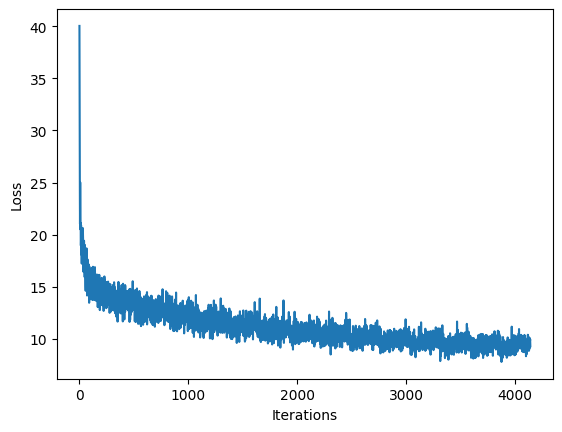

In [10]:
alphabet_size = 27  # _, a to z
embed_dim = 64  # Dimension of the embedding vector
hidden_size = 128  # Hidden state size in LSTM
num_layers = 2  

# Initialize the model
model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)

# Train the model
model.trainModel(vocab,epochs=15,batch_size=32)

In [12]:
# Sample input for autocomplete (starting letters of words)
sample = ['app', 'cak', 'butterf', 'icecrea','eati','drink','sleep','write','hiberna','driv','univ',
          'math', 'neur', 'engin','run','acquir','accen','aerop', 'comp', 'eleph', 'jupyt','eati','durab','follow','accord','success',
          'academ','absolute','access','accompl'
         ]

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: app, Completed: approcedures_
Original: cak, Completed: cakynot______
Original: butterf, Completed: butterfloor__
Original: icecrea, Completed: icecreaccount
Original: eati, Completed: eatinsidiens_
Original: drink, Completed: drinkaker____
Original: sleep, Completed: sleepublics__
Original: write, Completed: writentroo___
Original: hiberna, Completed: hibernaccount
Original: driv, Completed: drivotes_____
Original: univ, Completed: univancines__
Original: math, Completed: mathand______
Original: neur, Completed: neuratival___
Original: engin, Completed: enginacution_
Original: run, Completed: runatural____
Original: acquir, Completed: acquiresells_
Original: accen, Completed: accenetwash__
Original: aerop, Completed: aeropatio____
Original: comp, Completed: compolywerran
Original: eleph, Completed: elephela_____
Original: jupyt, Completed: jupytyping___
Original: eati, Completed: eatimagine___
Original: durab, Completed: durabecounds_
Original: follow, Completed: followebmot

Epoch 1, Loss: 14.848675727844238
Epoch 2, Loss: 14.009238243103027
Epoch 3, Loss: 13.230910301208496
Epoch 4, Loss: 12.706398963928223
Epoch 5, Loss: 12.823579788208008
Epoch 6, Loss: 13.137028694152832
Epoch 7, Loss: 12.6994047164917
Epoch 8, Loss: 11.903461456298828
Epoch 9, Loss: 12.392438888549805
Epoch 10, Loss: 11.760208129882812
Epoch 11, Loss: 11.701258659362793
Epoch 12, Loss: 12.410486221313477
Epoch 13, Loss: 12.074947357177734
Epoch 14, Loss: 11.495227813720703
Epoch 15, Loss: 11.377655029296875
Epoch 16, Loss: 10.683109283447266
Epoch 17, Loss: 11.810768127441406
Epoch 18, Loss: 11.350310325622559
Epoch 19, Loss: 11.460983276367188
Epoch 20, Loss: 11.815569877624512


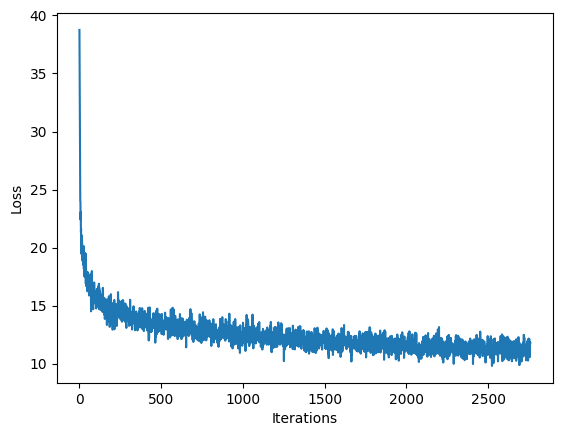

In [13]:
alphabet_size = 27  # _, a to z
embed_dim = 64  # Dimension of the embedding vector
hidden_size = 64  # Hidden state size in LSTM
num_layers = 2  

# Initialize the model
model = autocompleteModel(alphabet_size, embed_dim, hidden_size, num_layers)

# Train the model
model.trainModel(vocab,epochs=20,batch_size=64)

In [14]:
# Sample input for autocomplete (starting letters of words)
sample = ['app', 'cak', 'butterf', 'icecrea','eati','drink','sleep','write','hiberna','driv','univ',
          'math', 'neur', 'engin','run','acquir','accen','aerop', 'comp', 'eleph', 'jupyt','eati','durab','follow','accord','success',
          'academ','absolute','access','accompl'
         ]

# Get autocomplete predictions
predictions = model.autocomplete(sample)

# Print predictions
for i, prediction in enumerate(predictions):
    print(f"Original: {sample[i]}, Completed: {prediction}")

Original: app, Completed: apperfaora___
Original: cak, Completed: caknight_____
Original: butterf, Completed: butterfinnele
Original: icecrea, Completed: icecreapport_
Original: eati, Completed: eatinvour____
Original: drink, Completed: drinknows____
Original: sleep, Completed: sleepanks____
Original: write, Completed: writedringhot
Original: hiberna, Completed: hibernarbuq__
Original: driv, Completed: drivotibior__
Original: univ, Completed: univiedge____
Original: math, Completed: matharron____
Original: neur, Completed: neureflection
Original: engin, Completed: enginatirel__
Original: run, Completed: runatis______
Original: acquir, Completed: acquirequipia
Original: accen, Completed: accenored____
Original: aerop, Completed: aeroprotca___
Original: comp, Completed: comparility__
Original: eleph, Completed: elephopte____
Original: jupyt, Completed: jupythiesuall
Original: eati, Completed: eatinclide___
Original: durab, Completed: durabeers____
Original: follow, Completed: followebdia

## Section 3: Using and evaluating the model

(i) Feel free to initialize a autocompleteModel using different embedding dimensions and hidden layer sizes. Use different learning rates, epochs, batch sizes. Train the best model you can. Show the loss curves in you answers.

(ii) Evaluate it on different samples of partially filled in words. Eg: ["univ", "math", "neur", "engin"] etc. Please show outputs for different samples.

<font color='blue'>Comment on the results. Is it successful? Do you see familiar substrings in the generated tesxt such as "tion", "ing", "able" etc. What are your suggestions to improve the model?</font>

**Answer** 
<span style="color:green">
The model is able to generate substrings familiar to terms like 'ing, ed, ers' according to above results. However it seems to be struggling when words are bit lengthy. Increasing model capacity would be helpful. Increasing hidden size in LSTM cell , increasing the LSTM cell layers can be critical for improvements of the accruacy.
</span>.